In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, random 
path = 'path_of_stuff'    #defining path
os.chdir(path)      #changing directory to path
path

'/content/drive/MyDrive/Colab Notebooks/'

In [ ]:
#unzipping file
!unzip '/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images.zip'

Streaming output truncated to the last 5000 lines.
 extracting: Facial_emotion_images/train/surprise/9821.jpg  
 extracting: Facial_emotion_images/train/surprise/9835.jpg  
 extracting: Facial_emotion_images/train/surprise/9839.jpg  
 extracting: Facial_emotion_images/train/surprise/9859.jpg  
 extracting: Facial_emotion_images/train/surprise/9869.jpg  
 extracting: Facial_emotion_images/train/surprise/9879.jpg  
 extracting: Facial_emotion_images/train/surprise/9880.jpg  
 extracting: Facial_emotion_images/train/surprise/9882.jpg  
 extracting: Facial_emotion_images/train/surprise/9887.jpg  
 extracting: Facial_emotion_images/train/surprise/9894.jpg  
 extracting: Facial_emotion_images/train/surprise/9908.jpg  
 extracting: Facial_emotion_images/train/surprise/9918.jpg  
 extracting: Facial_emotion_images/train/surprise/9924.jpg  
 extracting: Facial_emotion_images/train/surprise/9942.jpg  
 extracting: Facial_emotion_images/train/surprise/9947.jpg  
 extracting: Facial_emotion_images

In [ ]:
# IMPORTING LIBRARIES

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import dataset, dataloader, ConcatDataset



#import fastai
from fastai.data.all import *         #might be all we need is these two
from fastai.vision.all import *
from fastai.text.all import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL as Image   
import time
import random
import copy
 
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from random import shuffle 
from shutil import copyfile
from shutil import copy
%matplotlib inline

import zipfile

The pretrained models to work with are here. Import them now, not when calling the model. It is much faster.

In [ ]:
from torchvision.models.resnet import resnet18, resnet34  

In [ ]:
!nvcc --version #checking for CUDA

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fqamwdtm
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-fqamwdtm
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=6cbdc0a78accda74e5f7436e274ba906128b1339aa85f49a1a28aa30f564aed1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_pfvgdtv/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin


directory /content/drive/MyDrive/Colab Notebooks/src already exists
Out bin /content/drive/MyDrive/Colab Notebooks/result.out


In [ ]:

# defining the path to our training images
path = Path('/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images')

# creating a pipeline for data assembly using fast.ai DataBlock api
emotions = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = RandomResizedCrop(200, min_scale=0.5),
                batch_tfms = aug_transforms(mult=2)
               )
# loading in the data with a batch size of 32, using fast.ai dataloaders
dls = emotions.dataloaders(path, bs = 32)

path

Path('/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images')

visializing data classes

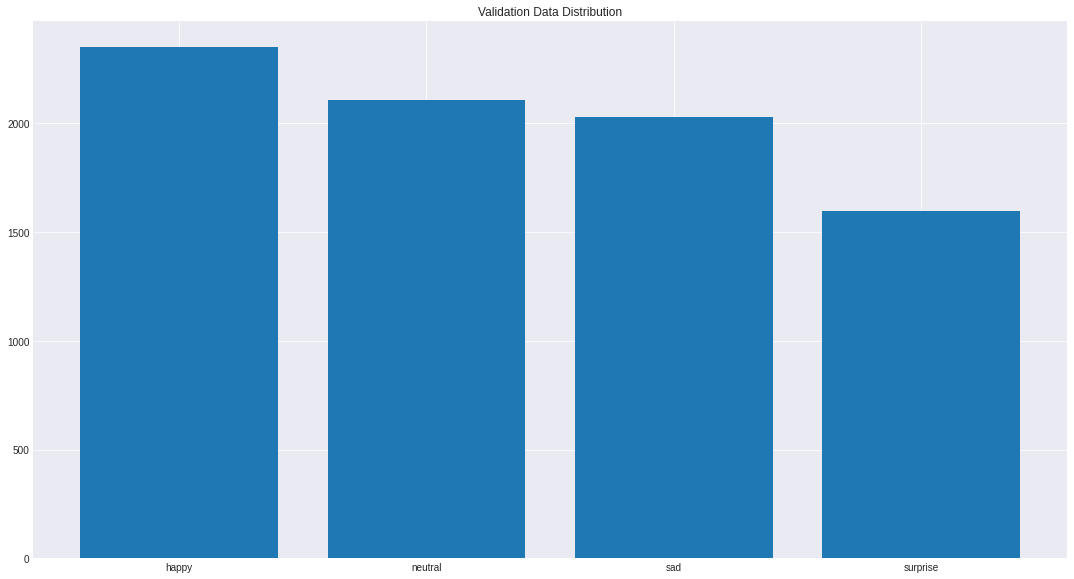

In [ ]:
from collections import Counter

plt.style.use('seaborn-darkgrid')

def category_count(class_items, title):
  
  list_of_classes = [path.parts[-2] for path in class_items]
  d = dict(sorted(Counter(list_of_classes).items()))

  fig, ax = plt.subplots(figsize=(15,8))
  fig.tight_layout()

  plt.title(title)
  ax.bar(d.keys(), d.values())

category_count(dls.valid_ds.items, 'Validation Data Distribution')

viewing augmented data

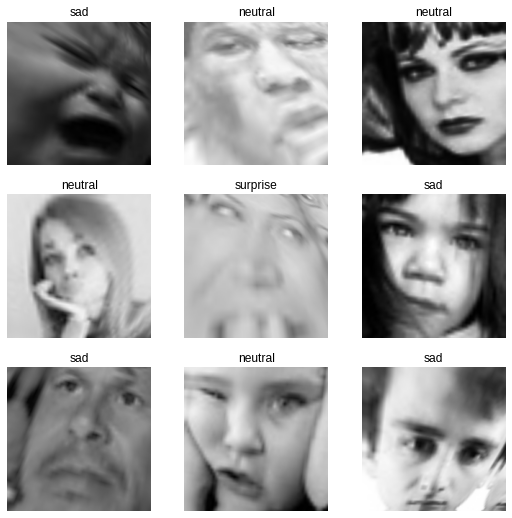

In [ ]:
dls.show_batch(max_n=9)


**Training** the model for 10 epochs.
First model is Resnet34, but the block to run it is deprecated. Keeping for comparison.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16() #install the pretrained model first, it is much faster

learn.fit_one_cycle(10) #cnn_learner is deprecated

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.490159,1.088508,0.565809,01:05
1,0.970768,0.780689,0.673429,01:05
2,0.862796,0.659134,0.732187,01:05
3,0.780438,0.620762,0.749134,01:05
4,0.756496,0.600124,0.760391,01:05
5,0.721253,0.569520,0.769050,01:06
6,0.671180,0.550397,0.773751,01:05
7,0.678616,0.543272,0.779688,01:05
8,0.657730,0.538251,0.780554,01:05
9,0.663795,0.536402,0.780430,01:06


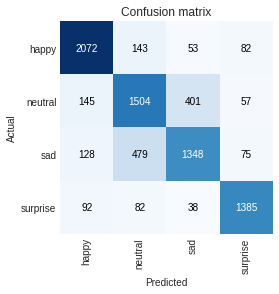

In [ ]:
# PLOTTING A CONFUSION MATRIX for 'learn' model

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

New model, 'vision_learn' using updated DataLoader, 'vision_learn', and finding best lr ahead of time.

SuggestedLRs(valley=0.0012022644514217973)

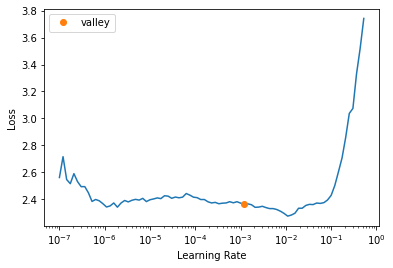

In [ ]:

from fastai.metrics import accuracy
vision_learn = vision_learner(dls, resnet34, metrics=accuracy)
vision_learn.lr_find() #finds its own best lr. Ideally, you run FIRST, then give to model.


Running 'vision_learn' model with predetermined lr, 15 epochs. Also resnet34.

In [ ]:
vision_learn.fit_one_cycle(15,0.0012022644514217973) #vision_learner is updated 

epoch,train_loss,valid_loss,accuracy,time
0,0.781589,0.632052,0.744681,01:04
1,0.765903,0.616649,0.751732,01:03
2,0.772818,0.611900,0.745794,01:03
3,0.733178,0.589567,0.760515,01:03
4,0.720094,0.584854,0.758783,01:02
5,0.724447,0.571942,0.761009,01:04
6,0.720448,0.549175,0.777462,01:03
7,0.705505,0.553345,0.776348,01:03
8,0.702259,0.543393,0.785750,01:03
9,0.674174,0.536343,0.779441,01:03


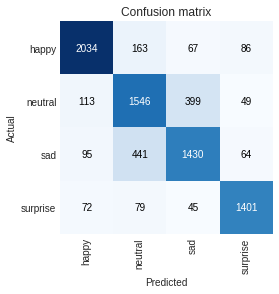

In [ ]:
# PLOTTING A CONFUSION MATRIX from vision_learn model

interpV = ClassificationInterpretation.from_learner(vision_learn)
interpV.plot_confusion_matrix()

**Found a callback that updates metrics (loss is default) in real time with each epoch.**

In [ ]:
v_learn = vision_learner(dls, resnet34, lr = 0.0006918309954926372, cbs=ShowGraphCallback())


plotting prediciton and accuracy

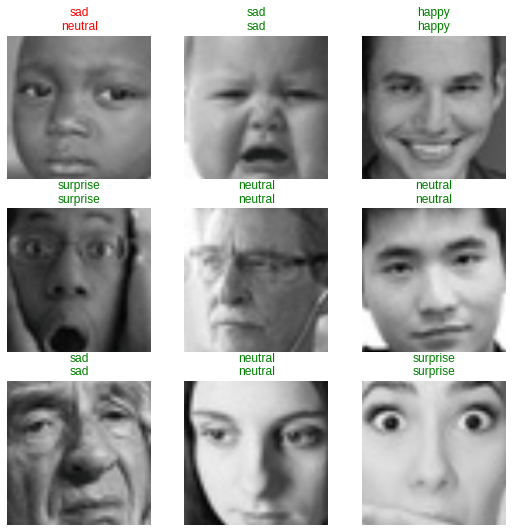

In [ ]:
Learner.show_results(vision_learn)


Plotting top losses for vision_learn model

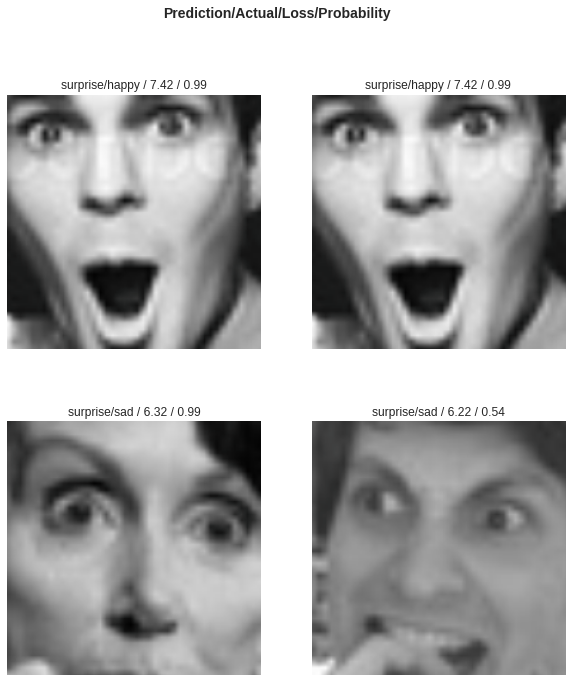

In [ ]:
interpV.plot_top_losses(4, figsize=(10,11))

Still trying to find how to plot the graphs for output metrics.

In [ ]:
 
interpretation = Interpretation(interpV, emotions, losses = emotions, act = accuracy )

NameError: ignored

In [ ]:
interpretation

Plotting top losses for vision_learn model

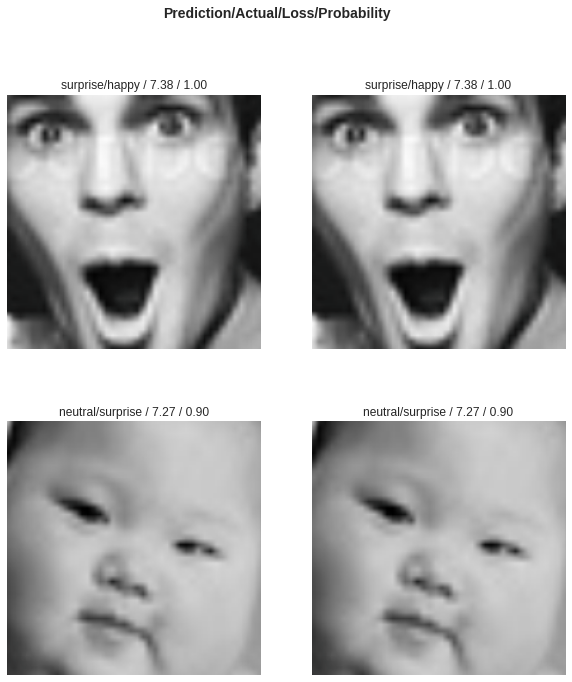

In [ ]:
interpV.plot_top_losses(4, figsize=(10,11))

**A sample of validation images**

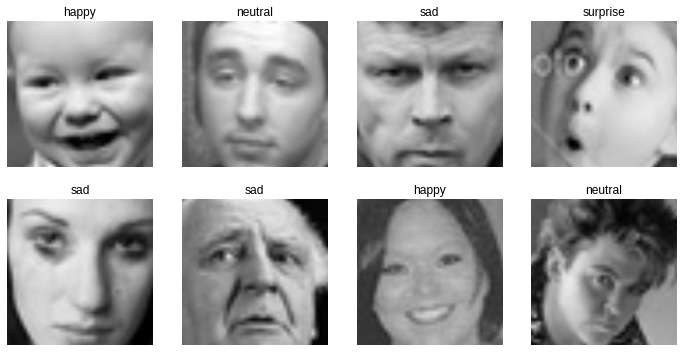

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

Using Resnet18

Model 'learn18', with cnn_learner, 10 epochs

In [ ]:
learn18 = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16()


/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn18 = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16()

learn.fit_one_cycle(10)

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.700958,0.555533,0.774245,01:06
1,0.722420,0.556114,0.773132,01:05
2,0.717026,0.547508,0.780430,01:06
3,0.715029,0.557925,0.776596,01:06
4,0.707179,0.550330,0.776101,01:05
5,0.657873,0.535173,0.783152,01:06
6,0.653659,0.517403,0.790203,01:05
7,0.659508,0.504584,0.799728,01:06
8,0.623393,0.503600,0.799233,01:04
9,0.638202,0.503650,0.798615,01:05


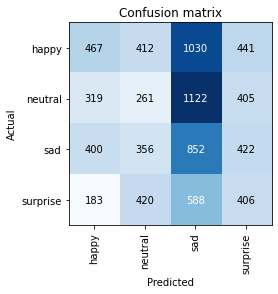

In [ ]:
# PLOTTING A CONFUSION MATRIX
#this is comparable to the problems with other pretrained models before

interp = ClassificationInterpretation.from_learner(learn18)
interp.plot_confusion_matrix()

From test set, we can get a sense of accuracy: